## Fuel Tank FEA Analysis
Ian Zabel, ibz@pdx.edu
### Introduction
The purpose of this analysis is to determine the failure criterea of the carbon fiber composite fuel tank walls. An Abaqus 6.14 model is developed assuming that the fuel tank is axisymmetric with some simplifications regarding the internals of the fuel tank. An initial model is developed and run, assuming there is no baffling or plumbing within the fuel tank, to ensure the composite definitions are sensible. A more advanced model is then developed that includes the internals expected to be present.
### Assumptions
To perform this analysis using a layered composite or aluminum, the pressure vessel is assumed to be thin-walled. To apply this assumption the wall thickness $t$ must be much smaller than a characteristic dimension $R$, in this case the tank radius $r$. The simplifed pressure vessel is assumed to be axisymmetric, and the advanced model vessel is assumed to by symmetric about both the $x,z$ and $y,z$ planes. To simplify manufacturing and design, both the oxidizer and fuel tanks are the same material, wall thickness, radius, and have the same hemispherical endcaps. One of the tanks will have a fuel line running through the center, while the other tank will only have an opening for that specific fuel line at the bottom.



FUEL TANK PARAMETERS
--------------------
Tank Volume, Eth.   = 0.035 m^3
Tank volume, Lox    = 0.034 m^3
Tank Length, Eth.   = 0.61 m
Tank Length, Lox    = 0.59 m
Tank Radius         = 0.13 m
Tank Wall Thickness = 2.0 mm

FUEL TANK MASS
--------------
Mass, Lox   = 38.47 kg
Mass, Eth.  = 29.47 kg
Mass, Prop. = 67.94 kg


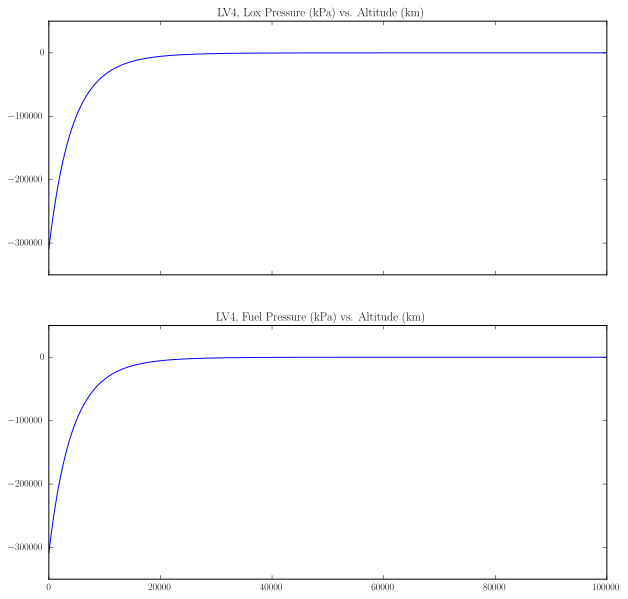

In [9]:
import math as m
import numpy as np
import matplotlib
import matplotlib.pyplot as plot
import pylab
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_formats=['svg']

# Ian Zabel
# Note: - Dimensions from LV4 MDO
#       - Atmo pressure from LV4 MDO
#       - All calculations assume hemisphere endcaps

# Dimensions

Do = 0.254  # Outer tank diameter (m)
Ro = Do/2   # Outer tank radius (m)
L = 1.2     # Overall tank length (m)
Lc = L-4*Ro # Cyl. tank length (m)
TW = 15     # Thin-walled assumption
#t = Ro/TW  # Wall thickness (m)
t = 0.002   # Wall thickness (m)
FS = 1.1    # Factor of safety

# Pressure
# Note: Use either np.all() or np.any() for ineq. def

def atmo(x):
    if np.all(x < 11000):
        T = 15.04-0.0065*x
        P = 101.3*((T+273.1)/288.1)**5.26
    elif np.all(11000 <= x) & np.all(x < 25000):
        T = -56.46
        P = 22.65*exp(1.73-0.00016*x) 
    else:
        T = -131.2+0.003*x
        P = 2.488*((T+273.1)/216.6)**(-11.4)

    rho = P/(0.29*(T+273.1)) # Density, ambient air (kg/m^3)
    Pa  = P*1000             # Pressure, ambient air (Pa)
    Ta  = T+273.1            # Temperature, ambient air (K)
    return Pa, rho, Ta

x  = np.arange(0, 1e5, 1) # Altitude (m)
Pa = atmo(x)[0]           # Atmospheric pressure (Pa)
Po = 50-Pa                # Pressure, lox, abs. (Pa)
Pf = 50-Pa                # Pressure, fuel, abs. (Pa)

# Propellant Parameters
# Note: Volume values TEMP

OF   = 1.3   # Oxidizer to fuel ratio
rhof = 852.3 # Density, ethanol fuel (kg/m^3)
rhoo = 1141  # Density, lox (kg/m^3)

'''
# Required Volume
Vo = 
vf = 
'''

Endo = 2*(4/3)*m.pi*Ro**3   # End cap volume, lox (m^3)
Endf = 2*(4/3)*m.pi*Ro**3   # End cap volume, fuel (m^3)
Lo   = L/(rhoo/(OF*rhof)+1) # Tank length, lox (m)
Lf   = L-Lo                 # Tank length, fuel (m)
CLo  = Lo-2*Ro              # Cyl. length, lox (m)
CLf  = Lf-2*Ro              # Cyl. length, fuel (m)

Vo = (2*(4/3)*m.pi*(Ro)**3)+CLo*m.pi*(Ro-t)**2 # Volume, lox (m^3)
Vf = (2*(4/3)*m.pi*(Ro)**3)+CLf*m.pi*(Ro-t)**2 # Volume, fuel (m^3)

mo = rhoo*Vo # Mass, lox (kg)
mf = rhof*Vf # mass, fuel (kg)
mp = mo+mf   # Mass, propellant (kg) 

# Stress, Cylindrical Portion

Sho = Po*Ro/t # Hoop stress, cyl., ox (Pa)
Shf = Pf*Ro/t # Hoop stress, cyl., fuel (Pa)
Sao = 0.5*Sho # Axial stress, cyl., ox (Pa)
Saf = 0.5*Shf # Axial stress, cyl., fuel (Pa)

# Stress, Spherical Portion
# Note: Static equilibrium, stress net resultant

Sno = Sao # Stress, endcaps, Ox (Pa)
Snf = Saf # Stress, endcaps, Fuel (Pa)

print('\n')
print('FUEL TANK PARAMETERS')
print('--------------------')
print('Tank Volume, Eth.   = {0:.3f} m^3'.format(Vf))
print('Tank volume, Lox    = {0:.3f} m^3'.format(Vo))
print('Tank Length, Eth.   = {0:.2f} m'.format(Lf))
print('Tank Length, Lox    = {0:.2f} m'.format(Lo))
print('Tank Radius         = {0:.2f} m'.format(Ro))
print('Tank Wall Thickness = {0:.1f} mm'.format(t*1000))
print('\nFUEL TANK MASS')
print('--------------')
print('Mass, Lox   = {0:.2f} kg'.format(mo))
print('Mass, Eth.  = {0:.2f} kg'.format(mf))
print('Mass, Prop. = {0:.2f} kg'.format(mp))

# Plotting
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
f, (ax1, ax2) = plot.subplots(2, sharex=True)
ax1.plot(x, Po)
ax1.yaxis.major.locator.set_params(nbins=6)
ax1.set_title('LV4, Lox Pressure (kPa) vs. Altitude (km)')
ax2.plot(x, Pf)
ax2.yaxis.major.locator.set_params(nbins=6)
ax2.set_title('LV4, Fuel Pressure (kPa) vs. Altitude (km)')
plot.show()